In [1]:
import itertools
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Functions

In [2]:
def clean_data(raw, z_threshold=2.5, min_listen_time=20):
    """
    Drops entries with abnormal listening_time (z-score too high or time too low).
    Also removes entries with unknown origin
    :param min_listen_time: entries where the user has listened for less than this (s) are dropped
    :param z_threshold: maximum z-score allowed in the dataset
    :param raw: raw data to be processed
    :return: clean dataset (pd.DataFrame)
    """
    print("Computing z-score...")
    z = np.abs(stats.zscore(raw["listening_time"]))

    print("Cleaning...")
    # Entries with a z-score above the threshold will be dropped (also instant-skips of listening_time < X)
    raw.drop(raw[z > z_threshold].index, inplace=True)
    raw.drop(raw[raw.listening_time < min_listen_time].index, inplace=True)
    return raw[(raw["origin"] != "unknown")]

In [3]:
def is_reco(origin):
    return origin[:3] == "rec" or origin == "flow"

In [4]:
def bin_artists(data, bin_amnt=25, separate_reco=True):
    """
    takes in raw data from streams (with added art_id -- see "formatting/add_artists.py") and bins artists together
    according to their "mainstream" status -- i.e. how much they are listened to.
    :param bin_amnt: amount of bins the artists will be put into AT MOST
    :param separate_reco: Whether or not to add a "recommended" column to the DF
    :param data: DataFrame ["user_id", "ts", "sng_id", "album_id", "listening_time", "listen_type", "origin", "art_id"]
    :return: the same DataFrame with added columns [..., "bin_nb", "recommended"] -- unless recommended is not wanted
    """
    print("Counting artist occurences...")
    artist_count = data["art_id"].value_counts(normalize=False).sort_values(ascending=True).to_frame() \
        .reset_index().rename(columns={"index": "art_id", "art_id": "plays"})
    artist_count["cumplays"] = artist_count["plays"].cumsum()

    print("Binning artists...")
    # Cutting into bin_amnt bins (duplicate bins allowed -- and necessary for small datasets and large amount of bins)
    artist_count["bin"] = pd.cut(artist_count["cumplays"], bin_amnt, duplicates="drop")
    print(f"Number of artists per bin: \n{artist_count.groupby('bin').size()}")

    # Assigning corresponding numbers to bins
    artist_count["bin_nb"] = (artist_count["bin"].cat.codes + 1).values
    print(f"Artists binned into {artist_count['bin_nb'].max()} categories.")

    data = data.merge(artist_count[["art_id", "bin_nb"]], left_on="art_id", right_on="art_id")

    # Adding 'recommended' column
    if separate_reco:
        data["recommended"] = data["origin"].map(is_reco)

    return data

In [5]:
def get_user_frame(data, bin_distribution):
    # Vectorized computing of the users' bin ratios
    user_frame = main_dist.to_frame()
    user_frame.columns = ["ratio"]

    # Our user_frame ends up with [user, bin_nb, ratio]
    user_plays = user_frame["ratio"].sum(level=0)
    user_frame = user_frame.unstack('bin_nb').divide(bin_distrib, level=1).divide(user_plays, axis=0).stack("bin_nb")

    user_frame = user_frame.reset_index()
    
    return user_frame

In [6]:
FILE_NAME = "../../data/artist_streams.csv"
SAVE_NAME = "../../data/mainstream_data.csv"
MIN_OBS = 100
SEPARATE_RECO = False
BIN_AMNT = 4

sns.set_palette(sns.color_palette("colorblind"))
sns.set_style("darkgrid")

In [7]:
print("Reading data...")
raw_data = pd.read_csv(FILE_NAME)
raw_data = clean_data(raw_data, z_threshold=3)
print(f"Data shape: {raw_data.shape[0]} lines, {raw_data.shape[1]} columns")

Reading data...
Computing z-score...
Cleaning...
Data shape: 1368080 lines, 8 columns


In [8]:
# Bin artists together
artist_data = bin_artists(raw_data, BIN_AMNT, SEPARATE_RECO)

print(f"Standard deviation of amount of plays per bin: {np.std(artist_data.groupby(['bin_nb']).size().values)}")

Counting artist occurences...
Binning artists...
Number of artists per bin: 
bin
(-1367.079, 342020.75]     7679
(342020.75, 684040.5]       437
(684040.5, 1026060.25]      135
(1026060.25, 1368080.0]      44
dtype: int64
Artists binned into 4 categories.
Standard deviation of amount of plays per bin: 584.0530797795693


In [9]:
 # Occurences of music plays in each bin
bin_distrib = artist_data.groupby("bin_nb").size()

# Reversing bin numbers -- just a dirty little workaround to have the "mainstreamest" bin be 1
artist_data["bin_nb"] = BIN_AMNT+1 - artist_data["bin_nb"]

# Normalized
bin_distrib /= bin_distrib.sum()

In [10]:
# Grouping users and their artist bin consumption
main_dist = artist_data.groupby(["user_id", "recommended", "bin_nb"] if SEPARATE_RECO
                                else ["user_id", "bin_nb"]).size()

print(f"Removing users with fewer than {MIN_OBS} observations...")
remove_idx = artist_data.groupby(["user_id"]).size()
remove_idx = remove_idx[remove_idx < MIN_OBS].index.unique()

main_dist.drop(labels=remove_idx, inplace=True)
print(f"Removed {len(remove_idx)} users.")

Removing users with fewer than 100 observations...
Removed 9 users.


In [11]:
print("Analyzing users...")
test_users = np.random.choice(main_dist.index.get_level_values("user_id").unique(), 6, replace=False)
recommended_choices = [True, False]
aggregate = pd.DataFrame(columns=["user_id", "recommended", "bin_nb", "ratio"])

Analyzing users...


# Users pre-binning based on recommendation usage

In [127]:
# Determining rate of recommended to organic for users
artist_data["recommended"] = artist_data["origin"].map(is_reco)
users_reco = artist_data.groupby(["user_id", "recommended"]).size().reset_index()
users_reco.columns = ["user_id", "recommended", "amnt"]

# Checking if all users have both types before division
users_reco_types = users_reco.groupby(["user_id"]).size()
users_reco_types = list(users_reco_types[users_reco_types == 1].index)

# Adding True column for False-only users and vice-versa
to_add = users_reco[users_reco["user_id"].isin(users_reco_types)]
to_add.loc[:, "recommended"] = ~to_add["recommended"]
# Not using 0 to avoid divisions -- in practice, this won't affect the bins
to_add.loc[:, "amnt"] = 1
users_reco = users_reco.append(to_add).sort_values(by=["user_id"])

users_reco.loc[:, "rate"] = 0
rec_amnts = users_reco[users_reco["recommended"] == True]["amnt"].values
org_amnts = users_reco[users_reco["recommended"]== False]["amnt"].values

# Changing users_reco into the final DataFrame
users_reco = users_reco[users_reco.recommended == True].drop(["recommended", "amnt"], axis=1)
users_reco.loc[:, "rate"] = rec_amnts / (rec_amnts + org_amnts)
print(users_reco)

                                       user_id      rate
1     00877d231a1d10859eefd4288ecc493fd1ea3589  0.456532
3     018ca9ed6e4c4a466ff2ac0cccc00b0733e8976e  0.179395
5     01d78f7619786f5f06843b5f1cb7d7b15a934731  0.003861
7     0282983996af7f6b2a27cfff67fc8982619561d6  0.173289
9     02eae2623eaf23461bbadd9c4f3ae1f659a90809  0.117953
...                                        ...       ...
1958  fe22a3978a595c3a63cb40558db7804956f8e1d7  0.017857
1960  fe8b03dc9d448192808c8cd2bf76657b7562b3ae  0.006729
1962  fea927761d221701b2bf1b6acc2de6d91d060071  0.004255
1964  ff7672529f1387bf35e1296f79009275287980a8  0.004113
1965  ff82befb6c2bcf11c638706bc27cf787128426de  0.002469

[1022 rows x 2 columns]


c:\users\quentin\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [128]:
# Adding nb of plays to users_reco in order to form bins with equal amounts of plays
users_reco = main_dist.groupby("user_id").sum().to_frame().merge(users_reco, left_on="user_id", right_on="user_id").sort_values("rate", ascending=True)
users_reco["cumplays"] = users_reco[0].cumsum()
users_reco

,user_id,0,rate,cumplays
996,faca30a972889b9f9dbe48fff9cc48929dc4c83b,4675,0.000214,4675
406,6543e42f5cfc84cfe2fb093d72b58b338dae4880,3213,0.000311,7888
754,b9115fc11d1a49ca11b1eff5d3d21dd96ed12720,2887,0.000346,10775
874,dac91821e5e928765ffcb26f5226d97f8894388c,8438,0.000356,19213
471,772454490ca8d33ffbd714e1b7614fd9f4940ecb,2720,0.000368,21933
...,...,...,...,...
653,9ff0a9ae1feee5bc83ab036558f4314f557f23c8,2219,0.900406,1362691
88,199b748f1902835734469bb8d9df38a91d3b6d91,1160,0.903448,1363851
123,2600ac94a475cf35303616de09d915c740a67386,2007,0.927753,1365858
205,39610b7c24ff424b8f242aa4f13da6765717f877,681,0.951542,1366539


In [129]:
USER_BINS = 4
# Cutting into bins
users_reco["u_bin"] = pd.cut(users_reco["cumplays"], USER_BINS, duplicates="drop")
print(f"Number of users per bin: \n{users_reco.groupby('u_bin').size()}")

# Assigning corresponding numbers to bins
users_reco["u_bin_nb"] = (users_reco["u_bin"].cat.codes + 1).values
print(f"Users binned into {users_reco['u_bin_nb'].max()} categories.")
users_reco.drop(["u_bin", "rate"], axis=1, inplace=True)

# sns.distplot(users_reco[users_reco["bin_nb"] == 4]["rate"], kde=False)

Number of users per bin: 
u_bin
(3311.84, 345465.0]       250
(345465.0, 686255.0]      265
(686255.0, 1027045.0]     286
(1027045.0, 1367835.0]    212
dtype: int64
Users binned into 4 categories.


In [131]:
# Amount of plays per user bin
main_dist.groupby("user_id").sum().to_frame().merge(users_reco, left_on="user_id", right_on="user_id").groupby("u_bin_nb").sum()

,0_x,0_y,cumplays
u_bin_nb,,,
1,344682,344682,46815193
2,340508,340508,136658228
3,340823,340823,241901611
4,341822,341822,252274333


In [132]:
# Testing correctness of user frame ratios
# user_frame = get_user_frame(main_dist, bin_distrib)
# user_frame.groupby("user_id")["ratio"].sum().values.mean()

user_frame = get_user_frame(main_dist, bin_distrib).merge(users_reco, left_on="user_id", right_on="user_id").drop(["user_id"], axis=1)

# Geometric mean
# user_bin_ratios = user_frame.groupby(["u_bin_nb", "bin_nb"])["ratio"].apply(stats.gmean).to_frame().reset_index()
user_bin_ratios = user_frame.groupby(["u_bin_nb", "bin_nb"])["ratio"].apply(np.mean).to_frame().reset_index()

print(user_bin_ratios.groupby("u_bin_nb")["ratio"].sum().values.mean())

4.013534343777951


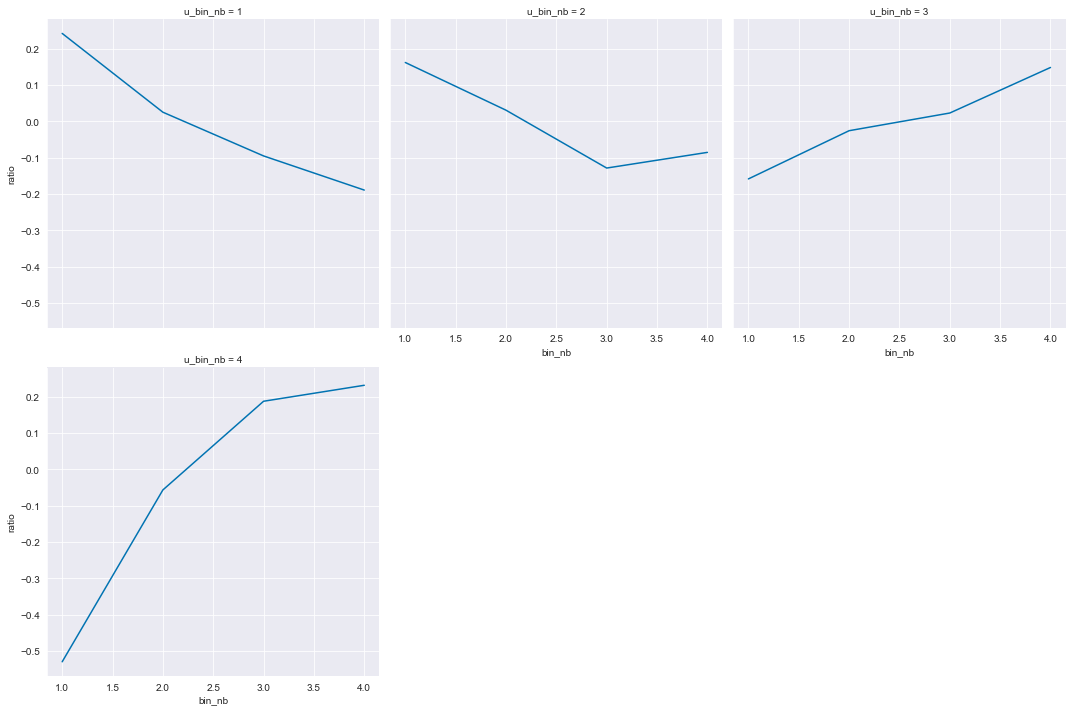

In [133]:
# Log ratio
user_bin_ratios["ratio"] = user_bin_ratios["ratio"].map(np.log)

#Plotting the first users
sns.relplot(x="bin_nb", y="ratio", kind="line", col="u_bin_nb", col_wrap=3, dashes=False, markers=True,
            estimator=None, data=user_bin_ratios, legend=False)

# Computing bin_distrib -- Vectorized version

In [49]:
user_frame = get_user_frame(main_dist, bin_distrib)

In [186]:
# Saving frame
user_frame.to_csv("mainstream_ratios.csv", index=False)

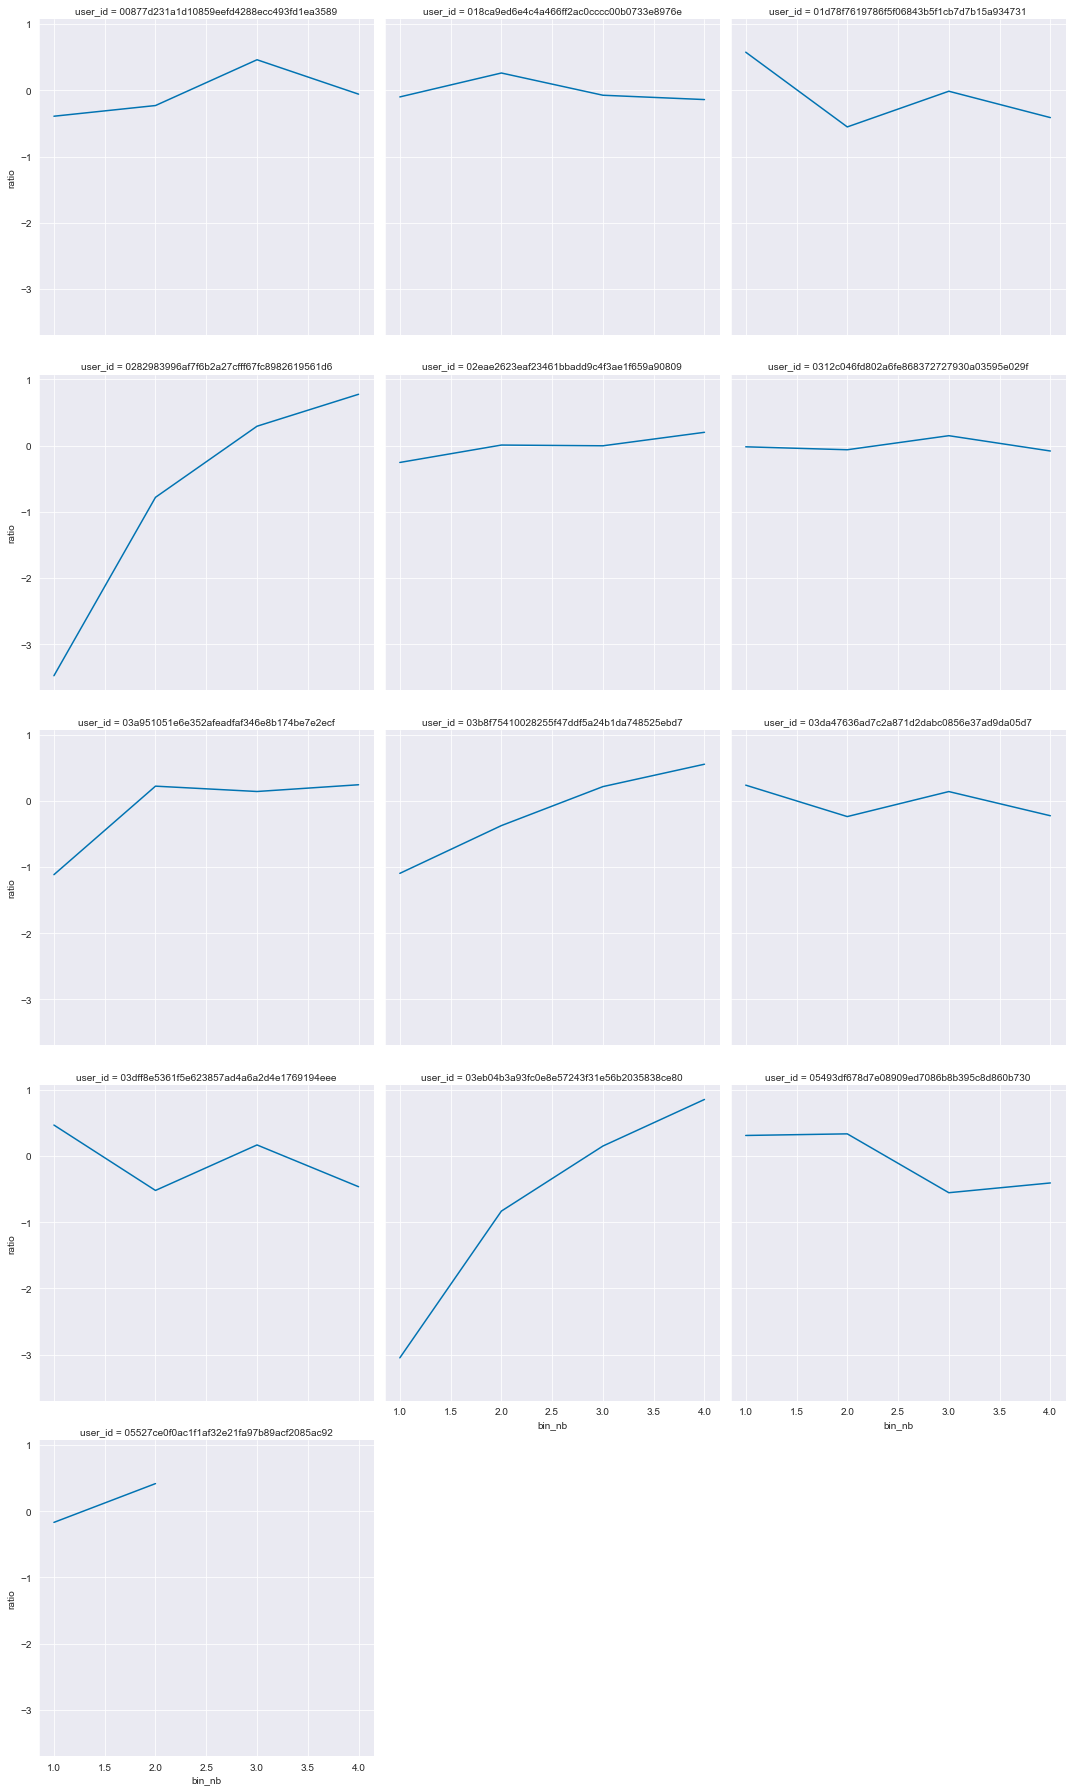

In [187]:
# Log for ratio
user_frame["ratio"] = user_frame["ratio"].map(np.log)

#Plotting the first users
sns.relplot(x="bin_nb", y="ratio", kind="line", col="user_id", col_wrap=3, dashes=False, markers=True,
            estimator=None, data=user_frame[:50], legend=False)

# Are recommendations favorizing mainstream content?

In [50]:
reco_mainstream = artist_data.merge(users_reco, left_on="user_id", right_on="user_id").drop(["ts", "listen_type", "listening_time", "album_id", "sng_id", "origin"], axis=1)

# For each user bin (recommendation based grouping)
reco_mainstream = reco_mainstream.groupby(["bin_nb", "u_bin_nb", "recommended"]).size()
reco_mainstream = reco_mainstream.to_frame().reset_index()
reco_mainstream.columns = ["bin_nb", "u_bin_nb", "recommended", "amount"]

# Testing stuff right there -- loop version because I have no idea how to vectorize this for now
test = reco_mainstream.groupby(["u_bin_nb", "recommended"]).mean().reset_index()

reco_mainstream["amount"] = reco_mainstream["amount"].astype(float)

for i, row in reco_mainstream.iterrows():
    reco_mainstream.at[i, "amount"] /= test[(test["u_bin_nb"] == reco_mainstream.at[i, "u_bin_nb"]) & (test["recommended"] == reco_mainstream.at[i, "recommended"])]["amount"]
    
reco_mainstream

,bin_nb,u_bin_nb,recommended,amount
0,1,1,False,1.333076
1,1,1,True,0.922078
2,1,2,False,1.278300
3,1,2,True,0.842454
4,1,3,False,1.185080
5,1,3,True,0.763248
6,1,4,False,0.984782
7,1,4,True,0.639797
8,1,5,False,0.906611
9,1,5,True,0.592846


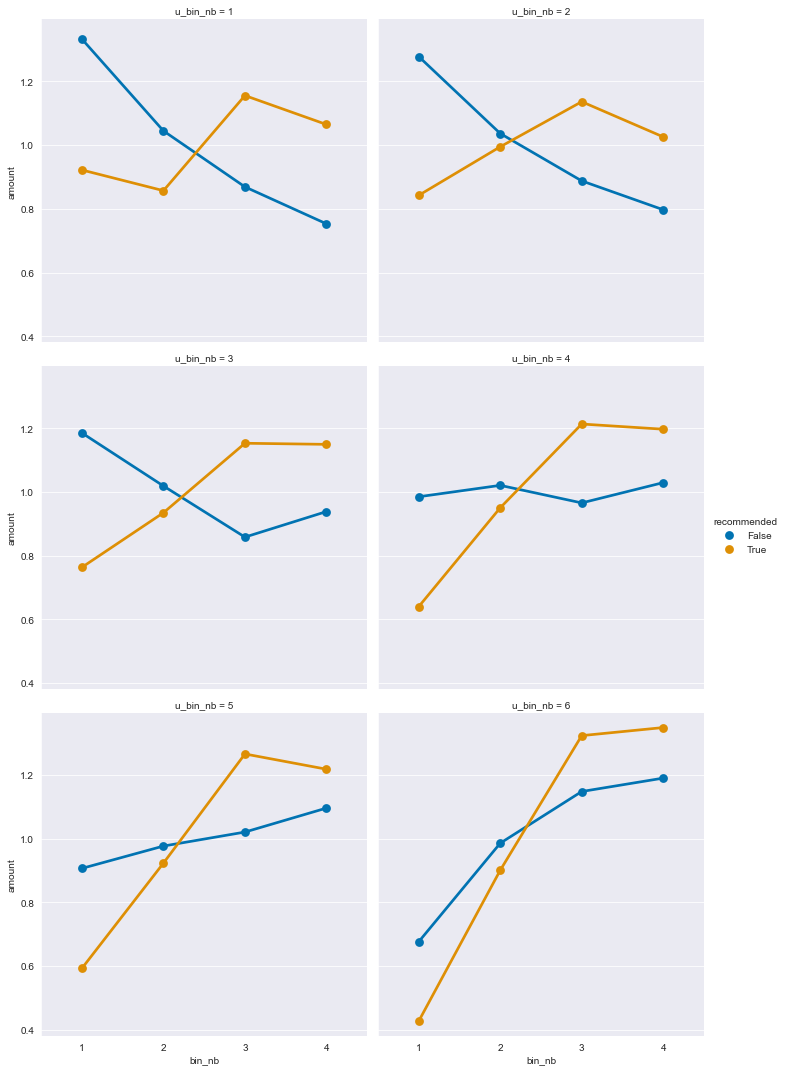

In [51]:
sns.catplot(x="bin_nb", y="amount", col="u_bin_nb", col_wrap=2, hue="recommended", kind="point", data=reco_mainstream)

In [52]:
# Mean mainstream bin for recommended vs. organic
test = reco_mainstream.groupby(["bin_nb", "recommended"])["amount"].sum().to_frame().reset_index()
print(test)
test_org = test[test["recommended"] == False]
test_rec = test[test["recommended"] == True]
print(f'Mean mainstream bin for organic plays: {(test_org["amount"] * test_org["bin_nb"]).sum() / test_org["amount"].sum()}')
print(f'Mean mainstream bin for recommended plays: {(test_rec["amount"] * test_rec["bin_nb"]).sum() / test_rec["amount"].sum()}')

   bin_nb  recommended    amount
0       1        False  6.364081
1       1         True  4.187368
2       2        False  6.083081
3       2         True  5.560794
4       3        False  5.749044
5       3         True  7.247809
6       4        False  5.803794
7       4         True  7.004029
Mean mainstream bin for organic plays: 2.4580229360644954
Mean mainstream bin for recommended plays: 2.7111874219814207


## Are organic non-mainstream listenings the result of previous recommendations?

In [53]:
# Finding songs for each user that were listened to only once 
single_listens = artist_data.groupby(["user_id", "sng_id"]).size()
single_listens = single_listens[single_listens < 2].to_frame().index

# Removing singletons from dataset
data_no_singletons = (artist_data[~pd.Series(list(zip(artist_data['user_id'], artist_data['sng_id']))).isin(single_listens)])[["user_id", "ts", "sng_id", "recommended"]]
data_no_singletons.sort_values(by=["user_id", "ts"], inplace=True)
data_no_singletons = data_no_singletons.reset_index().drop("index", axis=1)

data_no_singletons

,user_id,ts,sng_id,recommended
0,00877d231a1d10859eefd4288ecc493fd1ea3589,1471288384,865382,True
1,00877d231a1d10859eefd4288ecc493fd1ea3589,1471301804,4198567,False
2,00877d231a1d10859eefd4288ecc493fd1ea3589,1471329916,6345557,True
3,00877d231a1d10859eefd4288ecc493fd1ea3589,1471330121,15546830,True
4,00877d231a1d10859eefd4288ecc493fd1ea3589,1471330806,125089724,True
...,...,...,...,...
1174568,ff82befb6c2bcf11c638706bc27cf787128426de,1479497155,108692368,False
1174569,ff82befb6c2bcf11c638706bc27cf787128426de,1479538385,108692368,False
1174570,ff82befb6c2bcf11c638706bc27cf787128426de,1479538643,108692368,False
1174571,ff82befb6c2bcf11c638706bc27cf787128426de,1479711552,108692368,False


In [54]:
# Loop form -- maybe vectorizable at some point?
current_user = ""
reco_orga_table = pd.DataFrame(columns=["user_id", "sng_id", "org_to_rec"])
for i, row in data_no_singletons.iterrows():
    if current_user != row["user_id"]:
        # New user -- soft reset
        current_user = row["user_id"]
        user_dict = {}
    
    if row["sng_id"] not in user_dict:
        user_dict[row["sng_id"]] = row["recommended"]
    else:
        if row["recommended"] != user_dict[row["sng_id"]]:
            # Listen type different from the first time
            if (reco_orga_table[(reco_orga_table["user_id"] == current_user) & (reco_orga_table["sng_id"] == row["sng_id"])]).empty:
#             if [current_user, row["sng_id"]] not in reco_orga_table[reco_orga_table.columns[:2]].values:
                # Value not yet in the table
                reco_orga_table = pd.concat([reco_orga_table, pd.DataFrame([[current_user, row["sng_id"], row["recommended"]]], columns=["user_id", "sng_id", "org_to_rec"])],
                                           ignore_index=True)
                
    if i % 50000 == 0:
        print(i)

reco_orga_table

0
50000
100000
150000
200000
250000
300000
350000
400000
450000
500000
550000
600000
650000
700000
750000
800000
850000
900000
950000
1000000
1050000
1100000
1150000


,user_id,sng_id,org_to_rec
0,00877d231a1d10859eefd4288ecc493fd1ea3589,3599714,False
1,00877d231a1d10859eefd4288ecc493fd1ea3589,16571662,True
2,00877d231a1d10859eefd4288ecc493fd1ea3589,13789085,True
3,00877d231a1d10859eefd4288ecc493fd1ea3589,60842359,False
4,00877d231a1d10859eefd4288ecc493fd1ea3589,68437773,False
...,...,...,...
30656,ff7672529f1387bf35e1296f79009275287980a8,12565421,True
30657,ff7672529f1387bf35e1296f79009275287980a8,70506864,True
30658,ff7672529f1387bf35e1296f79009275287980a8,123883254,True
30659,ff7672529f1387bf35e1296f79009275287980a8,4619466,True


In [96]:
reco_orga_table.to_csv("reco_orga_table.csv", index=False)

In [27]:
reco_orga_table = pd.read_csv("reco_orga_table.csv")

In [59]:
song_bins = artist_data[["sng_id", "bin_nb"]].drop_duplicates().reset_index().drop(["index"], axis=1)

# Adding mainstream bins to reco_orga_table
reco_orga_table = reco_orga_table.merge(song_bins[["sng_id", "bin_nb"]], left_on="sng_id", right_on="sng_id")
reco_orga_table

,user_id,sng_id,org_to_rec,bin_nb_x,bin_nb_y
0,00877d231a1d10859eefd4288ecc493fd1ea3589,3599714,False,2,2
1,49185ae47dad71ce50fa5a29eceb56281a985002,3599714,False,2,2
2,78f2a25cf6ad18c7bd0b2a35cfadb68f2d43f201,3599714,False,2,2
3,b2edecfdb3037498933de482ed4142852ab00a90,3599714,True,2,2
4,c8309da83238bfb6f48ad6fb46b9174237bf67d1,3599714,True,2,2
...,...,...,...,...,...
30656,fdf2bdc014d1f3c3e69e4d4828d449378805c5d7,112439988,True,2,2
30657,fe016f7c946213bd53ca9b683b7314d24d2dbba9,109182794,True,4,4
30658,fe016f7c946213bd53ca9b683b7314d24d2dbba9,62986059,True,4,4
30659,fe016f7c946213bd53ca9b683b7314d24d2dbba9,73706048,False,4,4


In [60]:
reco_orga_count = reco_orga_table.groupby(["bin_nb", "org_to_rec"]).size().to_frame().reset_index()
reco_orga_count.columns = ["bin_nb", "org_to_rec", "count"]
reco_orga_count

KeyError: 'bin_nb'

In [57]:
# Normalization
means = reco_orga_count.groupby(["bin_nb"]).sum().reset_index()

reco_orga_count["count"] = reco_orga_count["count"].astype(float)
for i, row in reco_orga_count.iterrows():
    reco_orga_count.at[i, "count"] /= means[means["bin_nb"] == row["bin_nb"]]["count"]
reco_orga_count

,bin_nb,org_to_rec,count
0,1,False,0.292297
1,1,True,0.707703
2,2,False,0.349391
3,2,True,0.650609
4,3,False,0.390682
5,3,True,0.609318
6,4,False,0.382217
7,4,True,0.617783


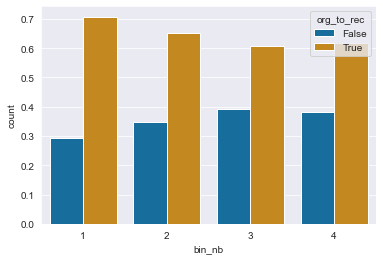

In [61]:
sns.barplot(x="bin_nb", y="count", hue="org_to_rec", data=reco_orga_count)

## bin_distrib -- Loop Version -- DEPRECATED

In [179]:
# Ratio calc loop
for user, reco in itertools.product(test_users, recommended_choices):
    # In case of no separation, we pass half of the iterations, which become useless
    if SEPARATE_RECO and reco:
        pass
    try:
        # to_frame() may raise an error on account of the data being size 1 (an int64 cannot be framed)
        if SEPARATE_RECO:
            user_dist = main_dist.loc[(user, reco)].to_frame()
        else:
            user_dist = main_dist[user].to_frame()
        user_dist.columns = ["ratio"]

        # Normalizing with regards to "average" consumption
        user_dist["ratio"] /= bin_distrib * user_dist["ratio"].sum()

        # Log
        user_dist["ratio"] = np.log(user_dist["ratio"])

        # Adding data to total frame for later seaborn plotting (useless for quick-and-dirty mpl)
        user_dist = user_dist.reset_index()
        user_dist["user_id"] = user
        user_dist["recommended"] = reco
        aggregate = pd.concat([aggregate, user_dist], ignore_index=True)
    except AttributeError as e:
        warnings.warn(f"User data of size 1 ignored for user {user}, recommended {reco}")
        pass

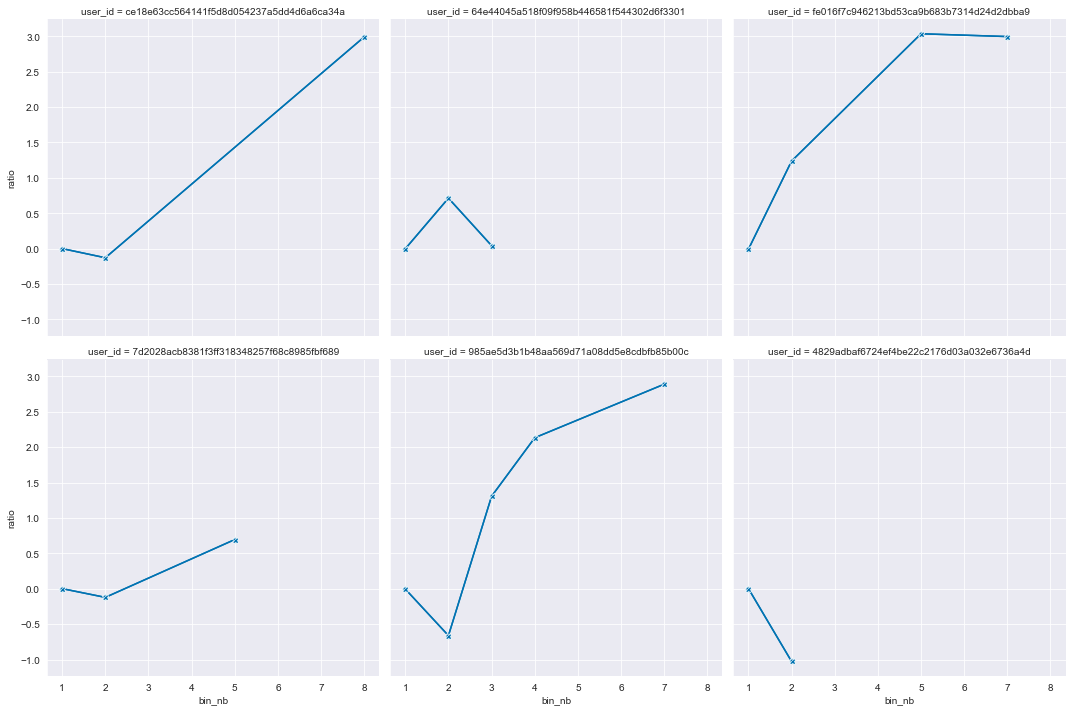

In [92]:
if not SEPARATE_RECO:
    sns.relplot(x="bin_nb", y="ratio", kind="line", col="user_id", col_wrap=3, dashes=False, markers=True,
                estimator=None, data=aggregate, legend=False, style="recommended")
else:
    sns.relplot(x="bin_nb", y="ratio", hue="recommended", style="recommended", kind="line", col="user_id",
                col_wrap=3, dashes=False, markers=True, estimator=None, data=aggregate, legend="brief")
sns.despine()
plt.show()